purpose: translate Rat GWAS into human orthologs (and maybe human to rat once a co-expression network made). After ortholog mapping, define seed gene sets. For ortho mapping- using bestmatch.

# Set-up

In [4]:
import os
import pandas as pd
import statsmodels.stats.multitest
from scipy import stats
import matplotlib.pyplot as plt
import re

In [5]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

# define ortholog dictionary

In [14]:
ortho=pd.read_csv('/tscc/projects/ps-palmer/brittany/orthology_ref_tbls/ORTHOLOGY-ALLIANCE_COMBINED_2024.tsv',sep='\t',skiprows=15)
#downloaded from https://www.alliancegenome.org/downloads#orthology on 11 June 2024
#filter for rat-human
ortho=ortho[(ortho['Gene1SpeciesName']=='Rattus norvegicus')&(ortho['Gene2SpeciesName']=='Homo sapiens')]
#filter for best match
ortho=ortho[ortho['IsBestScore']=='Yes']

In [15]:
ortho_best=ortho[ortho['IsBestScore']=='Yes']
ortho_best

,Gene1ID,Gene1Symbol,Gene1SpeciesTaxonID,Gene1SpeciesName,Gene2ID,Gene2Symbol,Gene2SpeciesTaxonID,Gene2SpeciesName,Algorithms,AlgorithmsMatch,OutOfAlgorithms,IsBestScore,IsBestRevScore
422849,RGD:69417,A1bg,NCBITaxon:10116,Rattus norvegicus,HGNC:5,A1BG,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422851,RGD:619834,A1cf,NCBITaxon:10116,Rattus norvegicus,HGNC:24086,A1CF,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
422857,RGD:2004,A2m,NCBITaxon:10116,Rattus norvegicus,HGNC:7,A2M,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422866,RGD:727913,A3galt2,NCBITaxon:10116,Rattus norvegicus,HGNC:30005,A3GALT2,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422868,RGD:621583,A4galt,NCBITaxon:10116,Rattus norvegicus,HGNC:18149,A4GALT,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567804,RGD:1309582,Zyg11a,NCBITaxon:10116,Rattus norvegicus,HGNC:32058,ZYG11A,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567811,RGD:1307814,Zyg11b,NCBITaxon:10116,Rattus norvegicus,HGNC:25820,ZYG11B,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
567819,RGD:620698,Zyx,NCBITaxon:10116,Rattus norvegicus,HGNC:13200,ZYX,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567823,RGD:1311189,Zzef1,NCBITaxon:10116,Rattus norvegicus,HGNC:29027,ZZEF1,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes


In [16]:
ortho_best_both=ortho_best[ortho_best['IsBestRevScore']=='Yes']

lose 1753 genes if filter for best reverse

In [6]:
ortho[ortho['AlgorithmsMatch']>2]

,Gene1ID,Gene1Symbol,Gene1SpeciesTaxonID,Gene1SpeciesName,Gene2ID,Gene2Symbol,Gene2SpeciesTaxonID,Gene2SpeciesName,Algorithms,AlgorithmsMatch,OutOfAlgorithms,IsBestScore,IsBestRevScore
422849,RGD:69417,A1bg,NCBITaxon:10116,Rattus norvegicus,HGNC:5,A1BG,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422851,RGD:619834,A1cf,NCBITaxon:10116,Rattus norvegicus,HGNC:24086,A1CF,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
422857,RGD:2004,A2m,NCBITaxon:10116,Rattus norvegicus,HGNC:7,A2M,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422866,RGD:727913,A3galt2,NCBITaxon:10116,Rattus norvegicus,HGNC:30005,A3GALT2,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,10,10,Yes,Yes
422868,RGD:621583,A4galt,NCBITaxon:10116,Rattus norvegicus,HGNC:18149,A4GALT,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567804,RGD:1309582,Zyg11a,NCBITaxon:10116,Rattus norvegicus,HGNC:32058,ZYG11A,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567811,RGD:1307814,Zyg11b,NCBITaxon:10116,Rattus norvegicus,HGNC:25820,ZYG11B,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes
567819,RGD:620698,Zyx,NCBITaxon:10116,Rattus norvegicus,HGNC:13200,ZYX,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|OrthoInspector|PANTHER|OrthoFind...,9,10,Yes,Yes
567823,RGD:1311189,Zzef1,NCBITaxon:10116,Rattus norvegicus,HGNC:29027,ZZEF1,NCBITaxon:9606,Homo sapiens,OMA|PhylomeDB|PANTHER|OrthoInspector|OrthoFind...,10,10,Yes,Yes


In [30]:
len(set(ortho_best['Gene1Symbol']))-len(set(ortho_best['Gene2Symbol']))

1002

In [31]:
len(set(ortho_best_both['Gene1Symbol']))-len(set(ortho_best_both['Gene2Symbol']))

27

lose 1006 if filter for >2 databases rather than best ortholog

# Read in rat genes (MAGMA)

In [28]:
test='final_mega'

In [29]:
if ((test=='meta')|(test=='mega')):
    loco_magma=pd.read_csv('magma/loco_meta_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif test=='gsem':
    loco_magma=pd.read_csv('magma/loco_gsem_7k_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif ((test=='final_cf')):
    loco_magma=pd.read_csv('magma/loco_final_cf_7k_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)
elif ((test=='final_mega')):
    loco_magma=pd.read_csv('magma/loco_final_mega_7k_win10.genes.out',delim_whitespace=True,index_col=None,skiprows=1)

# test cutoffs

## bonferroni

In [33]:
0.05/len(loco_magma)

2.6467630088401888e-06

In [26]:
loco_magma[loco_magma['P']<0.05/len(loco_magma)]

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
1844,Dmbt1,1,185607469,185706476,159,4,7679,5.2727,6.723100e-08
1856,Hmx3,1,186303237,186325201,19,2,7679,5.1859,1.075200e-07
1857,Hmx2,1,186309110,186336771,22,3,7679,5.3292,4.933400e-08
1858,Bub3,1,186320358,186350969,34,3,7679,5.0068,2.767400e-07
1859,Gpr26,1,186756001,186815435,137,4,7679,5.9550,1.300000e-09
1860,Cpxm2,1,186826797,186957222,272,5,7679,5.6812,6.689200e-09
2802,Gcnt4,2,28243325,28293082,176,5,7679,5.0792,1.894900e-07
2807,Enc1,2,28540670,28572591,73,4,7679,5.3447,4.527900e-08
3018,LOC120100761,2,84552685,84628998,163,4,7679,5.2046,9.722900e-08
3022,Zfp455,2,84702431,84743542,264,2,7679,5.3758,3.811200e-08


## FDR

In [32]:
#compare before and after ortholog mapping
loco_magma['FDR_corr']=statsmodels.stats.multitest.fdrcorrection(loco_magma['P'],alpha=0.05,method='indep',is_sorted=False)[1]

(array([1638., 1871., 1662., 1798., 1861., 1881., 1848., 2197., 2162.,
        1973.]),
 array([2.45583000e-05, 9.99611025e-02, 1.99897647e-01, 2.99834191e-01,
        3.99770735e-01, 4.99707279e-01, 5.99643823e-01, 6.99580367e-01,
        7.99516912e-01, 8.99453456e-01, 9.99390000e-01]),
 <BarContainer object of 10 artists>)

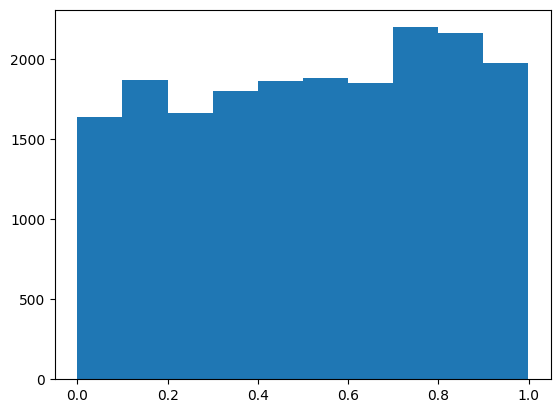

In [28]:
plt.hist(loco_magma['FDR_corr'])

In [29]:
loco_magma[loco_magma['FDR_corr']<0.05]

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,FDR_corr
2,Vom2r6,1,1204035,1232755,2,1,7679,2.9894,0.001398,0.043083
31,Sf3b5,1,7347040,7367752,35,3,7679,3.0396,0.001185,0.041438
32,Plagl1,1,7467295,7527229,186,7,7679,3.4542,0.000276,0.025352
36,Fuca2,1,7875986,7910777,124,8,7679,3.1107,0.000933,0.037945
37,Pex3,1,7902508,7964474,211,9,7679,3.1542,0.000805,0.036368
...,...,...,...,...,...,...,...,...,...,...
18106,LOC679899,19,35500991,35521375,60,4,7679,2.9030,0.001848,0.048431
18109,Dhx38,19,37502893,37540135,89,6,7679,3.9192,0.000044,0.010110
18110,Txnl4b,19,37520157,37549827,60,5,7679,3.2305,0.000618,0.033764
18112,Dhodh,19,37541858,37583327,122,7,7679,3.3172,0.000455,0.029613


# merge in human orthologs

In [34]:
loco=loco_magma.merge(ortho_best[['Gene1Symbol','Gene2Symbol']], left_on='GENE',right_on='Gene1Symbol',how='left').dropna().reset_index().drop(['index','Gene1Symbol'],axis=1)
loco.columns=['GENE', 'CHR', 'START', 'STOP', 'NSNPS', 'NPARAM', 'N', 'ZSTAT', 'P',
       'Q', 'HM_ORTHO']

In [35]:
loco

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,Q,HM_ORTHO
0,Raet1l,1,1969433,1994410,2,1,7679,-0.036540,0.51457,0.731811,RAET1E
1,Lrp11,1,2038307,2118115,146,4,7679,0.170790,0.43219,0.672647,LRP11
2,Pcmt1,1,2101756,2170354,146,3,7679,0.336480,0.36826,0.622060,PCMT1
3,Nup43,1,2134427,2167887,69,3,7679,0.305040,0.38017,0.632846,NUP43
4,Lats1,1,2150411,2203640,55,3,7679,0.157190,0.43755,0.676307,LATS1
...,...,...,...,...,...,...,...,...,...,...,...
16459,Hace1,20,49025312,49161103,206,4,7679,-1.590300,0.94411,0.967043,HACE1
16460,Grik2,20,52125325,52843061,1299,2,7679,0.135960,0.44593,0.683565,GRIK2
16461,Ascc3,20,53500137,53805446,347,1,7679,0.031385,0.48748,0.714920,ASCC3
16462,Sim1,20,53817601,53917219,152,1,7679,0.090251,0.46404,0.698890,SIM1


In [36]:
if test=='meta':
    loco.to_csv('magma/seed_genes/loco_win10_annot.tsv',sep='\t', index=False)
elif test=='gsem':
    loco.to_csv('magma/seed_genes/loco_gsem_annot.tsv',sep='\t', index=False)
elif ((test=='final_cf')):
    loco.to_csv('magma/seed_genes/loco_final_cf_win10_annot.tsv',sep='\t',index=False)
elif ((test=='final_mega')):
    loco.to_csv('magma/seed_genes/loco_final_mega_win10_annot.tsv',sep='\t',index=False)

# externalizing (MAGMA)

In [3]:
set=['munged','orig']
file=set[1]

In [4]:
ext_magma=pd.read_csv('magma/ext_'+file+'.genes.out',delim_whitespace=True,index_col=None,skiprows=0)

In [8]:
gene_loc=pd.read_csv('/tscc/projects/ps-palmer/brittany/magma_v1/NCBI38/NCBI38.gene.loc',sep='\t',header=None)
gene_loc.columns=['ID','CHR','START','STOP','STAND','GENE_NAME']

In [6]:
ext_magma=gene_loc[['ID','GENE_NAME']].merge(ext_magma, left_on='ID',right_on='GENE',how='right').reset_index().drop(['index','GENE'],axis=1)
ext_magma.columns=['ID', 'GENE', 'CHR', 'START', 'STOP', 'NSNPS', 'NPARAM', 'N','ZSTAT', 'P']

In [9]:
ext_magma['Q']=statsmodels.stats.multitest.fdrcorrection(ext_magma['P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [10]:
ext_magma.to_csv('magma/seed_genes/ext_'+file+'_annot.tsv',sep='\t',index=False)

# externalizing (FUSION)

In [40]:
ext_fus=pd.read_csv('ext_FUSION/FUSION_concat/ext2019_GTEx.Brain_Nucleus_accumbens_basal_ganglia.dat',delim_whitespace=True)

In [44]:
ext_fus=ext_fus.dropna(subset=['ID','TWAS.P'],axis=0).reset_index()

In [50]:
ext_fus=ext_fus.drop('index',axis=1)

In [46]:
ext_fus['Q']=statsmodels.stats.multitest.fdrcorrection(ext_fus['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [53]:
ext_fus.to_csv('ext_FUSION/ext_fusion_NACC_seed.tsv',sep='\t',index=False)

# externalizing 2 factor (magmav1.08)

from supplemental tables in The Genetic and Neural Substrates of Externalizing Behavior. previous magma version but i need access from the university that published it to get sumstats so we're going to use this . pvalue cutoff from paper for bonferroni

In [6]:
ext_db=pd.read_csv('ext_2factor/MAGMA_v108_DB_bonf.tsv',sep='\t')
ext_rtb=pd.read_csv('ext_2factor/MAGMA_v108_RTB_bonf.tsv',sep='\t')

In [9]:
ext_db['Q']=statsmodels.stats.multitest.fdrcorrection(ext_db['P'],alpha=0.05,method='indep',is_sorted=False)[1]
ext_rtb['Q']=statsmodels.stats.multitest.fdrcorrection(ext_rtb['P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [12]:
ext_db.to_csv('ext_2factor/MAGMA_v108_DB_bonf.tsv',sep='\t',index=None)
ext_rtb.to_csv('ext_2factor/MAGMA_v108_RTB_bonf.tsv',sep='\t',index=None)

# locomotor mega (FUSION)

In [6]:
def extract_IDs(annot, type=None):
    if (type=='gene'):
        #print('returning ENSRNOG')
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOG')]
        if len(ls)>0:
            return(ls[0])
    elif (type=='transcript'):
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOT')]
        if len(ls)>0:
            return(ls[0])
    else:
        return [x for x in re.split('[:.]', annot) if x.startswith('ENSR')]

In [7]:
loco_dir='loco_twas_dan/'

In [8]:
fus_rn_map=pd.read_csv(loco_dir+'rn7.gene.txt',sep='\t')

/tmp/ipykernel_3514057/1034971248.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  fus_rn_map=pd.read_csv(loco_dir+'rn7.gene.txt',sep='\t')


In [9]:
#downloaded from ensembl BioMart on 9 July 2024 for mRatBN7.2
gene_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.gene_map.gtf.gz',compression='gzip',sep='\t')
transcript_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.transcript_map.gtf.gz',compression='gzip',sep='\t')

In [10]:
#locomotor activity TWAS calculated by FUSION by Dan Munroe
tbl=pd.read_csv('loco_twas_dan/regressedlr_combined_locomotor.dat',sep='\t')
tbl['TISSUE']=[s.split('.')[1] for s in tbl.PANEL]
tbl['TYPE_MOD']=[s.split('.')[2] for s in tbl.PANEL]

In [11]:
tbl['ID_ls']=tbl['ID'].apply(extract_IDs)
tbl['gene_id']=tbl['ID'].apply(extract_IDs,type='gene')
tbl['tran_id']=tbl['ID'].apply(extract_IDs,type='transcript')

In [12]:
#add in gene name
t=tbl.merge(gene_tbl[['Gene stable ID','Gene name']], left_on='gene_id',right_on='Gene stable ID',how='left').drop('Gene stable ID', axis=1)
t=t.merge(transcript_tbl[['Transcript stable ID','Transcript name']], left_on='tran_id',right_on='Transcript stable ID',how='left').drop('Transcript stable ID', axis=1)
#t_exp=t[t.TYPE_MOD=='expression']

In [13]:
t=t[(t['TYPE_MOD']=='expression')&(t['TISSUE']=='NAcc2')]

In [14]:
0.05/len(t)

9.338812103100487e-06

In [93]:
t=t.merge(ortho_best[['Gene1Symbol','Gene2Symbol']], left_on='Gene name',right_on='Gene1Symbol',how='left')

In [97]:
t=t.dropna(subset=['Gene2Symbol','Gene1Symbol','TWAS.P'],axis=0).drop(['Gene1Symbol'],axis=1)

In [107]:
t['Q']=statsmodels.stats.multitest.fdrcorrection(t['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]

/tmp/ipykernel_3504319/663195165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['Q']=statsmodels.stats.multitest.fdrcorrection(t['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]


In [109]:
t=t.rename(columns = {'Gene2Symbol':'human_ortholog'})

In [110]:
t.to_csv(loco_dir+'/loco_fusion_NACC_seed.tsv',sep='\t',index=False)